In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fachrulfirman","key":"f02156c6479c81184a505e2d79220023"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c ieee-fraud-detection

 85% 100M/118M [00:00<00:00, 155MB/s] 
100% 118M/118M [00:00<00:00, 141MB/s]


In [3]:
! unzip ieee-fraud-detection.zip -d /content/ieee-fraud-detection

Archive:  ieee-fraud-detection.zip
  inflating: /content/ieee-fraud-detection/sample_submission.csv  
  inflating: /content/ieee-fraud-detection/test_identity.csv  
  inflating: /content/ieee-fraud-detection/test_transaction.csv  
  inflating: /content/ieee-fraud-detection/train_identity.csv  
  inflating: /content/ieee-fraud-detection/train_transaction.csv  


In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
from sklearn.model_selection import RandomizedSearchCV

# Read csv file into dataframe

In [2]:
train_transaction = pd.read_csv('/content/ieee-fraud-detection/train_transaction.csv')
train_identity = pd.read_csv('/content/ieee-fraud-detection/train_identity.csv')
test_transaction = pd.read_csv('/content/ieee-fraud-detection/test_transaction.csv')
test_identity = pd.read_csv('/content/ieee-fraud-detection/test_identity.csv')

In [3]:
train_data = train_transaction.merge(train_identity, on='TransactionID', how='left')
test_data = test_transaction.merge(test_identity, on='TransactionID', how='left')
test_data.columns = test_data.columns.str.replace('^id-', 'id_', regex=True)

# Handling missing values

In [4]:
def missing_info(column, data):
  na = data[column].isna()
  count = na.sum()
  total_count = data.shape[0]
  missing_percentage = np.round((count/total_count)*100,2)
  return (count, missing_percentage)

def missing_info_train(data):
  columns_missing_info = []
  for column in data:
    count, missing_percentage = missing_info(column, data)
    if(count):
      columns_missing_info.append([column, count, f'{missing_percentage}%'])
  column_names = ['Kolom', 'Jumlah', 'Persentase']
  missing_info_data = pd.DataFrame(data = columns_missing_info, columns = column_names)
  return missing_info_data

missing_train_data = missing_info_train(train_data)
missing_train_data.sort_values(by='Persentase',ascending=False)

,Kolom,Jumlah,Persentase
397,id_24,585793,99.2%
380,id_07,585385,99.13%
381,id_08,585385,99.13%
394,id_21,585381,99.13%
399,id_26,585377,99.13%
...,...,...,...
319,V285,12,0.0%
318,V284,12,0.0%
314,V280,12,0.0%
313,V279,12,0.0%


In [5]:
null_value_train = [f for f in train_data.columns if train_data[f].isna().sum()/len(train_data)>0.7]
null_value_test = [f for f in test_data.columns if test_data[f].isna().sum()/len(test_data)>0.7]
null_columns = list(set(null_value_train + null_value_test))

if 'isFraud' in null_columns:
  null_columns.remove('isFraud')

train_data.drop(null_columns, axis=1, inplace=True)
test_data.drop(null_columns, axis=1, inplace=True)

In [6]:
one_value_train = [f for f in train_data.columns if train_data[f].value_counts(dropna=False,normalize=True).values[0]>0.7]
one_value_test = [f for f in test_data.columns if test_data[f].value_counts(dropna=False,normalize=True).values[0]>0.7]
one_columns = list(set(one_value_train + one_value_test))

if 'isFraud' in one_columns:
  one_columns.remove('isFraud')

train_data.drop(one_columns, axis=1, inplace=True)
test_data.drop(one_columns, axis=1, inplace=True)

In [7]:
cat_columns = train_data.select_dtypes(include=['object']).columns.tolist()
train_data[cat_columns] = train_data[cat_columns].fillna('missing')
test_data[cat_columns] = test_data[cat_columns].fillna('missing')

In [8]:
num_columns = train_data.select_dtypes(include=['float64','int64']).columns.tolist()
train_data[num_columns] = train_data[num_columns].fillna(-999)
num_columns = test_data.select_dtypes(include=['float64','int64']).columns.tolist()
test_data[num_columns] = test_data[num_columns].fillna(-999)

# Encoding features

In [9]:
le = LabelEncoder()
for column in cat_columns:
  train_data[column] = le.fit_transform(train_data[column])
  test_data[column] = le.fit_transform(test_data[column])

# Splitting dataset

In [10]:
x = train_data.drop(['TransactionID','isFraud'], axis=1)
y = train_data['isFraud']
x_test = test_data.drop(['TransactionID'], axis=1)

In [11]:
x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size = 0.3, random_state = 24, stratify=y)

# Evaluation matrix

In [12]:
def evaluation_matrix(y_validation, y_predict_proba, verbose = True):
  scores = {}
  y_predict_class =  [0  if x < 0.5 else 1 for x in y_predict_proba]
  scores['ROC_AUC'] = roc_auc_score(y_validation, y_predict_proba)
  scores['Accuracy'] = accuracy_score(y_validation, y_predict_class)
  scores['Precision'] = precision_score(y_validation, y_predict_class)
  scores['Recall'] = recall_score(y_validation, y_predict_class)
  scores['F1-Score'] = f1_score(y_validation, y_predict_class, average='binary')
  conf_matrix = confusion_matrix(y_validation, y_predict_class)
  cm = pd.DataFrame(conf_matrix, columns=np.unique(y_validation), index = np.unique(y_validation))
  if verbose:
    print('ROC_AUC {:0.2f}'.format(scores['ROC_AUC']))
    print('Accuracy {:0.2f}'.format(scores['Accuracy'] ))
    print('Precision {:0.2f}'.format(scores['Precision']))
    print('Recall {:0.2f}'.format(scores['Recall']))
    print('F1-Score %0.2f' %scores['F1-Score'] )
  return scores, cm

# Klasifikasi dengan XGBoost

In [44]:
xgbc_params = {
  'colsample_bytree':0.8,
  'eval_metric':'logloss',
  'objective':'binary:logistic',
  'learning_rate':0.25,
  'max_depth':16,
  'min_child_weight':20,
  'n_estimators':100,
  'nthread':-1,
  'random_state':24,
  'scale_pos_weight':18,
  'subsample':0.8}

model = xgb.XGBClassifier(**xgbc_params)
model.fit(x_train, y_train)
y_predict = model.predict(x_validation)
results, cm = evaluation_matrix(y_validation, y_predict, verbose = True)

ROC_AUC 0.86
Accuracy 0.98
Precision 0.72
Recall 0.73
F1-Score 0.73


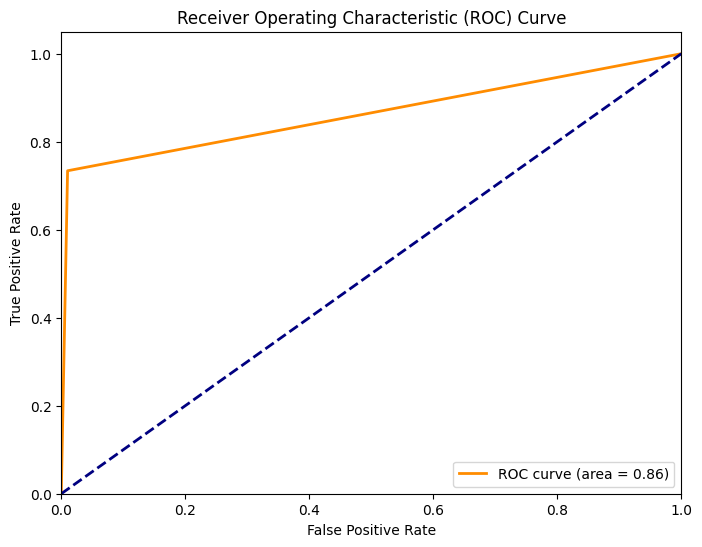

In [45]:
fpr, tpr, thresholds = roc_curve(y_validation, y_predict)
roc_auc = roc_auc_score(y_validation, y_predict)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

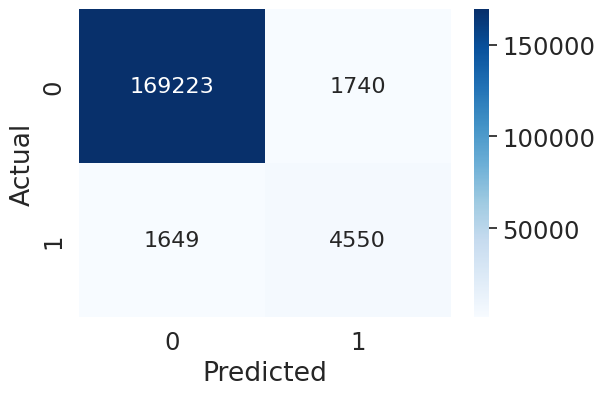

In [46]:
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (6, 4))
sns.set(font_scale=1.6)
sns.heatmap(cm, cmap='Blues', annot=True,annot_kws={'size': 16}, fmt='g')
plt.show()

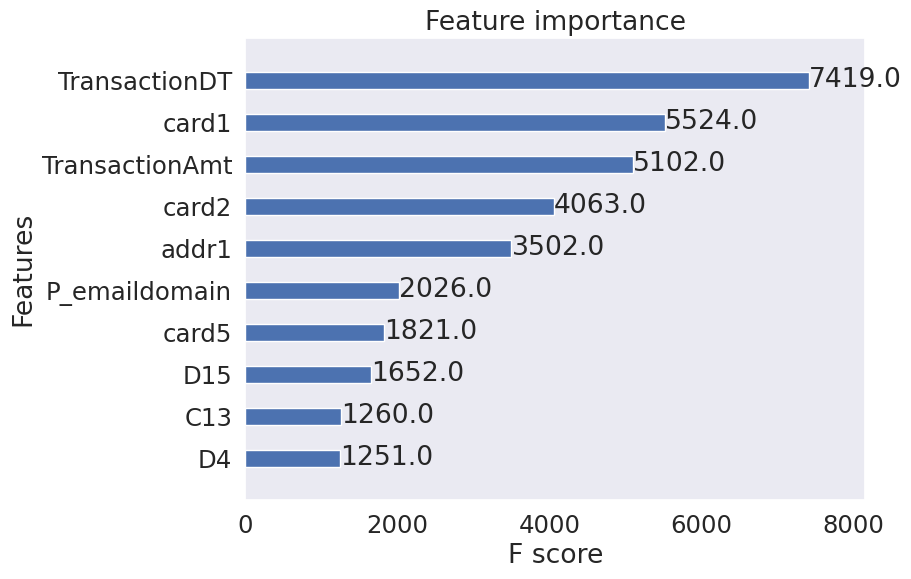

In [47]:
plt.rcParams['figure.figsize'] = (8, 6)
xgb.plot_importance(model, max_num_features=10, grid=False, height=0.4)
plt.show()

In [48]:
df = pd.DataFrame()
df['TransactionID'] = test_data.TransactionID
df['isFraud'] = model.predict(x_test)
df.to_csv('submission.csv', index=False)
df['isFraud'].value_counts().rename_axis('isFraud').to_frame('Count').rename(index={0:'0 (No)', 1:'1 (Yes)'}).sort_values(by='isFraud')

,Count
isFraud,
0 (No),491125
1 (Yes),15566


In [49]:
df

,TransactionID,isFraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0
...,...,...
506686,4170235,0
506687,4170236,0
506688,4170237,0
506689,4170238,0
